In [0]:
#파이토치 인스톨
!pip install torch torchvision
import torch
print(torch.__version__)

1.5.0+cu101


In [0]:
%matplotlib inline
#데이터 생성과 화면 표시를 위한 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

#실험결과 비교를 위해 시드 고정
seed = 444
np.random.seed(seed)
torch.manual_seed(seed)

In [0]:
class proData:
    
    #데이터 쪼개기, 학습, 평가, 테스트 3개부분으로
    def splitData(self,x,y):
        origin = len(x)
        trainn = int(origin*0.8)
        valn = int(origin*0.9)

        # 경향성을 없애기 위한 셔플
        s = np.arange(x.shape[0])
        np.random.shuffle(s)
        x = x[s]
        y = y[s]

        trainX, trainY = x[:trainn, :], y[:trainn]
        valX, valY = x[trainn:valn,:], y[trainn:valn]
        testX,testY = x[valn:,:], y[valn:]

        return trainX,trainY,valX,valY,testX,testY

In [0]:
import torch.nn as nn
# 모델 정의
    
class MLPModel(nn.Module):
    # input = 입력값 개수, output = 출력값 개수
    def __init__(self,_input,_output,_hidden_layers): 
        super(MLPModel, self).__init__()
        self.inputv = _input
        self.outputv = _output
        nodes = [_input] + _hidden_layers + [_output]
        self.depth = len(nodes)
        linears = [nn.Linear(nodes[i], nodes[i+1]) for i in range(self.depth-1)]
        self.linears = nn.ModuleList(linears)
        self.relu = nn.ReLU()
        
    
    def forward(self, x):
    # 인스턴스(샘플) x가 인풋으로 들어왔을 때 모델이 예측하는 y값을 리턴합니다.
        for linear in self.linears[:-1]: 
          x = linear(x)
          x = self.relu(x)
        x = self.linears[-1](x)

        return x

In [0]:
class epochClass():

    def __init__(self,_model,_optimizer,_device):
        self.model = _model
        self.optimizer = _optimizer
        self.reg_loss = nn.MSELoss()
        self.device = _device
        self.list_epoch = []
        self.list_val_loss = []
        self.list_mae = []
        self.list_mae_epoch = []

    def getModelOptim(self):
        return self.model, self.optimizer

    def getEpochList(self):
        return self.list_epoch, self.list_val_loss, self.list_mae, self.list_mae_epoch

    def startEpoch(self,epoch,interval,train_X,train_y,val_X,val_y,test_X,test_y):
    

        for i in range(epoch):    
            # ====== Train ====== #
            self.model.train() # model을 train 모드로 세팅합니다. 반대로 향후 모델을 평가할 때는 eval() 모드로 변경할 겁니다 
            self.optimizer.zero_grad() # optimizer에 남아있을 수도 있는 잔여 그라디언트를 0으로 다 초기화해줍니다.
            
            input_x = torch.Tensor(train_X)
            true_y = torch.Tensor(train_y)
            #Gpu로 데이터 옮기기
            input_x = input_x.to(device)
            true_y = true_y.to(device)
            #
            pred_y = self.model(input_x)
            #
            
            loss = self.reg_loss(pred_y.squeeze(), true_y)
            loss.backward() # backward()를 통해서 그라디언트를 구해줍니다.
            self.optimizer.step() # step()을 통해서 그라디언틀르 바탕으로 파라미터를 업데이트 해줍니다. 
            self.list_epoch.append(i)
            
            # ====== Validation ====== #
            self.model.eval()
            self.optimizer.zero_grad()
            input_x = torch.Tensor(val_X)
            true_y = torch.Tensor(val_y)
            #GPU로 데이터 옮기기
            input_x = input_x.to(device)
            true_y = true_y.to(device)
            #
            pred_y = self.model(input_x)   
            loss = self.reg_loss(pred_y.squeeze(), true_y)
            self.list_val_loss.append(loss.item())
            

            # ====== Evaluation ======= #
            if i % interval == 0: # 200회의 학습마다 실제 데이터 분포와 모델이 예측한 분포를 그려봅니다.
                
                # ====== Calculate MAE ====== #
                self.model.eval()
                self.optimizer.zero_grad()
                input_x = torch.Tensor(test_X)
                true_y = torch.Tensor(test_y)
                #
                input_x = input_x.to(device)
                true_y = true_y.to(device)
                #
                pred_y = self.model(input_x)
                mae = self.reg_loss(true_y, pred_y.squeeze())
                self.list_mae.append(mae)
                self.list_mae_epoch.append(i)
                
                print(i, mae)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

class DataLoader():
    
    def fileload(self,PATH):
        x = []
        y = []
        with open(PATH,'r') as f:
            lines = f.readlines()
            for line in lines:
                line = line[:-1]
                temp = line.split(',')
                temp = temp[1:]
                x.append([int(temp[0]),int(temp[1]),int(temp[2]),int(temp[3]),int(temp[4])])
                y.append(int(temp[-1]))
        return x,y

    def fileloadn(self,PATH,n):
        x = []
        y = []
        with open(PATH,'r') as f:
            lines = f.readlines()
            for line in lines:
                line = line[:-1]
                temp = line.split(',')
                if len(temp) != n*5 + 2:
                    continue
                temp2 = []
                for i in temp[1:-1]:
                    temp2.append(int(i))
                x.append(temp2)
                y.append(int(temp[-1]))
        return x,y

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
d = DataLoader()
X = [] 
y = []
for i in range(1):
    xt, yt = d.fileloadn('/content/gdrive/My Drive/datas/ndata'+str(i)+'.txt',3)
    X = X + xt
    y = y + yt

In [0]:

inX = np.array(X)
iny = np.array(y).T

p = proData()
train_X, train_y, val_X, val_y, test_X, test_y = p.splitData(inX,iny)

In [0]:
import torch.optim as optim
from sklearn.metrics import mean_absolute_error
# 학습에 필요한 파라미터 정의

model = MLPModel(15,1,[200,150,100,50,25,10]) # Model을 생성해줍니다.
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
#modelPath = '/content/gdrive/My Drive/model.pt'
#model.load_state_dict(torch.load(modelPath))
# ===== Construct Optimizer ====== #
lr = 0.005 # Learning Rate를 하나 정해줍니다. (원할한 학습을 위해 손을 많이 탑니다)
optimizer = optim.Adam(model.parameters(), lr=lr) # Optimizer를 생성해줍니다.


In [0]:
# 학습 시작
ep = epochClass(model,optimizer,device)
ep.startEpoch(4000,200,train_X,train_y,val_X,val_y,test_X,test_y)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([145, 1])) that is different to the input size (torch.Size([145])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 tensor(8.2149e+09, device='cuda:0', grad_fn=<MeanBackward0>)
200 tensor(1.0177e+10, device='cuda:0', grad_fn=<MeanBackward0>)
400 tensor(1.0249e+10, device='cuda:0', grad_fn=<MeanBackward0>)
600 tensor(1.0179e+10, device='cuda:0', grad_fn=<MeanBackward0>)
800 tensor(1.0180e+10, device='cuda:0', grad_fn=<MeanBackward0>)
1000 tensor(1.0216e+10, device='cuda:0', grad_fn=<MeanBackward0>)
1200 tensor(1.0256e+10, device='cuda:0', grad_fn=<MeanBackward0>)
1400 tensor(1.0352e+10, device='cuda:0', grad_fn=<MeanBackward0>)
1600 tensor(1.0359e+10, device='cuda:0', grad_fn=<MeanBackward0>)
1800 tensor(1.0344e+10, device='cuda:0', grad_fn=<MeanBackward0>)
2000 tensor(1.0334e+10, device='cuda:0', grad_fn=<MeanBackward0>)
2200 tensor(1.0329e+10, device='cuda:0', grad_fn=<MeanBackward0>)
2400 tensor(1.0385e+10, device='cuda:0', grad_fn=<MeanBackward0>)
2600 tensor(1.0381e+10, device='cuda:0', grad_fn=<MeanBackward0>)
2800 tensor(1.0727e+10, device='cuda:0', grad_fn=<MeanBackward0>)
3000 tensor(1.039

In [0]:
# 학습결과 차트로 보여주기
list_epoch,list_val_loss,list_mae,list_mae_epoch = ep.getEpochList()


In [0]:
class pltClass():

    def __init__(self,_list_epoch, _list_val_loss, _list_mae_epoch, _list_mae):
        self.list_epoch = _list_epoch
        self.list_val_loss = _list_val_loss
        self.list_mae_epoch = _list_mae_epoch
        self.list_mae = _list_mae


    def printFigure(self):
        fig = plt.figure(figsize=(24,5))


        # ====== valid plot ====== #
        ax2 = fig.add_subplot(1, 2, 1)
        ax2.plot(self.list_epoch, self.list_val_loss, '--', label='val')
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
        #ax1.set_ylim(0, 5)
        ax2.grid()
        ax2.legend()
        ax2.set_title('epoch vs loss')

        # ====== test plot ====== #
        ax3 = fig.add_subplot(1, 2, 2)
        ax3.plot(self.list_mae_epoch, self.list_mae, marker='x', label='test')

        ax3.set_xlabel('epoch')
        ax3.set_ylabel('mae')
        ax3.grid()
        ax3.legend()
        ax3.set_title('epoch vs loss')


        plt.show()



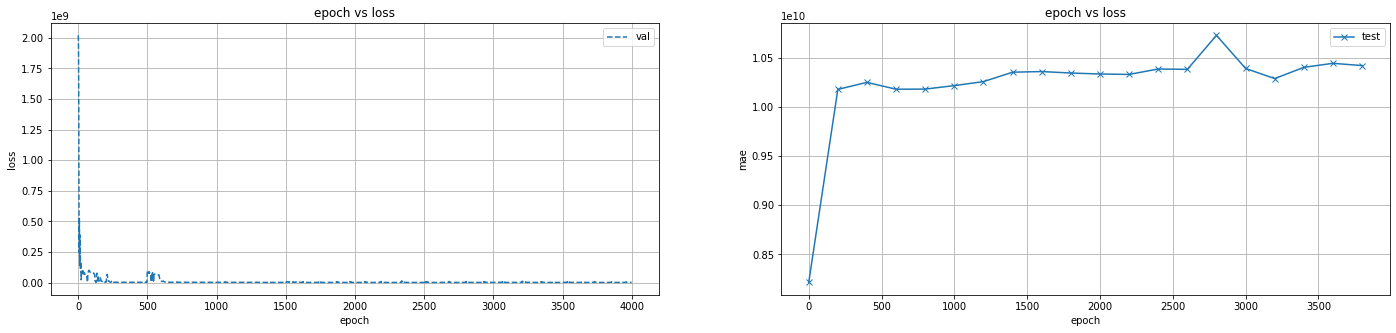

In [0]:

pltc = pltClass(list_epoch,list_val_loss,list_mae_epoch,list_mae)
pltc.printFigure()

In [0]:
model.to('cpu')
model.eval()

prediction = model(torch.Tensor(test_X))
pred = []
real = test_y
for i in prediction[:].T:
    for j in i:
        pred.append(j.item())

print(real)
print(pred)

[  8610   9410   6575   1880    967  10530   6115   9285   6060   9940
   2790  30000   4000   8850   2470  10080  41350  12080  50700  26950
 111500   6810   9085  10035  16500  25050  10710  16500   1910  16300
  11500  70000  10835   2370  11185  13515   3210   7215   7035   7265
  13500  10810  69800   3620   5025 113500   5375  12950  10430  10945
  24300  43200   5020   7300   5230  12265  16220   1020  14955   2955
   5850  13350  10815  12885 104660   7200  86500 800000 101500   7650
   3385   9375  12125  11985  17350  17700  10290   3345   1950  24350
  10375   4450  11475   3585  42850  25600   6840 149500   7480   6240
  13850 130500   3440   8735   9365   4140   7580   1005  39100   8090
  10325   3210    748 101460  12965 139315 128000    946   7500   3120
  10865  57730   3670   7830   2200   1030   2830   1410  10775   9930
   2370  24575   6575  20145   3530   7970  32500  15035   9100 124000
  50800  12050   8675 215500   9310   1205 111575   4640   2730   8890
  3010

In [0]:
modelPath = '/content/gdrive/My Drive/model.pt'
torch.save(model.state_dict(), modelPath)

Text(0.5, 1.0, 'pred vs real')

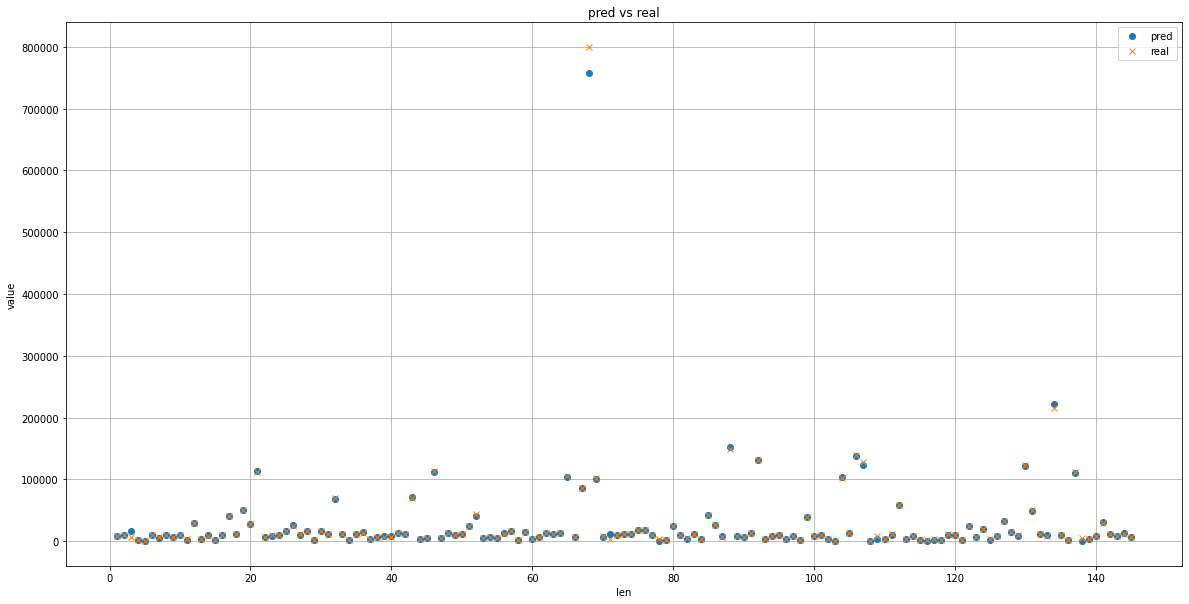

In [0]:
fig = plt.figure(figsize=(20,10))
xl = [n for n in range(1,len(pred)+1)]

# ====== valid plot ====== #
ax2 = fig.add_subplot(1, 1, 1)
ax2.plot(xl, pred, 'o', label='pred')
ax2.plot(xl, real, 'x', label='real')
ax2.set_xlabel('len')
ax2.set_ylabel('value')
#ax1.set_ylim(0, 5)
ax2.grid()
ax2.legend()
ax2.set_title('pred vs real')